In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")
from dataloader.svdd_dataloader import CollisionLoader_new
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import librosa
import numpy as np
from pyod.models.abod import ABOD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from load_data import load_data
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment 
%matplotlib inline

In [2]:
train_imu,train_audio,train_spec,val_imu,val_audio,val_spec,val_imu_normal,val_audio_normal,val_spec_normal,total_list = load_data()

train_combine = np.concatenate([np.mean(train_audio,axis=-1),train_imu],axis=1)

test_audio_all = np.concatenate([val_audio_normal,val_audio],axis=0)
test_imu_all   = np.concatenate([val_imu_normal,val_imu],axis=0)
test_combine = np.concatenate([np.mean(test_audio_all,axis=-1),test_imu_all],axis=1)

labels_all = np.concatenate([np.zeros(val_audio_normal.shape[0]),np.ones(val_audio.shape[0])])

In [3]:
clf_audio = ABOD().fit(np.mean(train_audio,axis=-1))
clf_imu = ABOD().fit(train_imu)
clf_all = ABOD().fit(train_combine)

In [4]:
scores_audio      = clf_audio.decision_function(np.mean(test_audio_all,axis=-1))
scores_imu        = clf_imu.decision_function(test_imu_all)
scores_all        = clf_all.decision_function(test_combine)



In [5]:
eval_metrics_audio = ts_metrics(labels_all, scores_audio)
eval_metrics_imu = ts_metrics(labels_all, scores_imu+scores_audio)
result_audio = eval_metrics_audio
result_imu = eval_metrics_imu
eval_metrics_all = ts_metrics(labels_all, scores_all)
result_all = eval_metrics_all

print(result_audio[:-2])
print(result_imu[:-2])
print(result_all[:-2])

# np.save("ABOD_p",result_imu[-2])
# np.save("ABOD_r",result_imu[-1])

(0.9492519770069112, 0.9238094784350188, 0.8779839680063046, 0.8533969010727056, 0.9040404040404041)
(0.9119037828947368, 0.8141895797344298, 0.8261801578902589, 0.746938775510204, 0.9242424242424242)
(0.5400333516081872, 0.44708473640730656, 0.5698767391472026, 0.3990895295902883, 0.9962121212121212)


In [ ]:
np.save("/home/iot/collision_detect/svdd/ploting/ABOD (95.0)_p",result_audio[-2])
np.save("/home/iot/collision_detect/svdd/ploting/ABOD (95.0)_r",result_audio[-1])

In [6]:
from sklearn import metrics
precision, recall, thresholds= metrics.precision_recall_curve(labels_all, (scores_audio))
epsilon = 1e-10

f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(best_threshold)
indoor_group = []
outdoor_group = []
mach_group = []
coli_group = []
for idx, filepath in enumerate(total_list):
    parts = filepath.split('/')
    sequence = parts[-2]  # e.g., 'iseq2', 'iseq5', 'seq16'
    if sequence=='seq16':
        file_number = int(parts[-1].split('.')[0])  # Extract file number from filename (e.g., '0' from '0.npy')

    # Check if the file belongs to the indoor group (iseq2, iseq5, or seq16 with 0-104.npy)
    if sequence in ['iseq2', 'iseq5'] or (sequence == 'seq16' and  file_number >= 104):
        indoor_group.append(idx)  # Add the index of the file
    elif sequence in ['seq15', 'seq10'] or (sequence == 'seq16' and  file_number < 104):
        outdoor_group.append(idx)  # Add the index of the file
    elif sequence in ['bl', 'br','fl','fr']:
        mach_group.append(idx)  # Add the index of the file
    else:
        coli_group.append(idx)  # Add the index of the file

indoor_losses = [scores_audio[idx] for idx in indoor_group]
outdoor_losses = [scores_audio[idx] for idx in outdoor_group]
mach_losses = [scores_audio[idx] for idx in mach_group]
coli_losses = [scores_audio[idx] for idx in coli_group]

-0.00011341621380863307


In [7]:
# Given threshold
threshold = best_threshold
# Example threshold, replace with actual value

# True labels for indoor and outdoor groups
true_labels_indoor = [0] * len(indoor_losses)  # All indoor samples are normal
true_labels_outdoor = [0] * len(outdoor_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = indoor_losses + outdoor_losses
all_true_labels = true_labels_indoor + true_labels_outdoor

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_indoor = sum(predicted_labels[i] == true_labels_indoor[i] for i in range(len(indoor_losses))) / len(indoor_losses) if len(indoor_losses) > 0 else 0
accuracy_outdoor = sum(predicted_labels[len(indoor_losses) + i] == true_labels_outdoor[i] for i in range(len(outdoor_losses))) / len(outdoor_losses) if len(outdoor_losses) > 0 else 0

print("\nIndoor Group Accuracy:")
print(f"  Accuracy: {accuracy_indoor:.4f}")

print("\nOutdoor Group Accuracy:")
print(f"  Accuracy: {accuracy_outdoor:.4f}")


Overall Accuracy:
  Accuracy: 0.8988

Indoor Group Accuracy:
  Accuracy: 0.8707

Outdoor Group Accuracy:
  Accuracy: 0.9303


In [8]:
true_labels_mach = [1] * len(mach_losses)  # All indoor samples are normal
true_labels_coli = [1] * len(coli_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = mach_losses + coli_losses
all_true_labels = true_labels_mach + true_labels_coli

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_mach = sum(predicted_labels[i] == true_labels_mach[i] for i in range(len(mach_losses))) / len(mach_losses) if len(mach_losses) > 0 else 0
accuracy_coli = sum(predicted_labels[len(mach_losses) + i] == true_labels_coli[i] for i in range(len(coli_losses))) / len(coli_losses) if len(outdoor_losses) > 0 else 0

print("\nmach Group Accuracy:")
print(f"  Accuracy: {accuracy_mach:.4f}")

print("\ncoli Group Accuracy:")
print(f"  Accuracy: {accuracy_coli:.4f}")

Overall Accuracy:
  Accuracy: 0.9028

mach Group Accuracy:
  Accuracy: 0.9630

coli Group Accuracy:
  Accuracy: 0.7921


In [9]:
coli_losses

[-6.388718220955036e-07,
 -2.1260786023418498e-07,
 -0.00026834827192100867,
 -3.665013761720633e-10,
 -2.607302732564936e-06,
 -2.023792772869699e-06,
 -3.870817346615209e-06,
 -2.3043635928581736e-07,
 -0.0018168431937196847,
 -3.40479275874714e-07,
 -1.3854912560548176e-05,
 -1.5946036845915187e-06,
 -0.00010274431221741604,
 -6.859512797111533e-06,
 -3.0360008082227813e-06,
 -0.00043046313054244026,
 -0.00029144226942345365,
 -0.00013063306881199439,
 -1.816639192607694e-05,
 -0.00018153537280261688,
 -0.0002818677969361013,
 -0.00014644806639088308,
 -4.542044723775146e-06,
 -0.0010888830165233566,
 -1.1350319784825044e-06,
 -2.515674189199948e-06,
 -6.125993860106241e-05,
 -0.0003314409571955099,
 -2.511663722325545e-06,
 -0.0002624617322611165,
 -6.488407380741923e-08,
 -1.2191172313284771e-05,
 -5.3317935262417863e-05,
 -2.050456745671528e-05,
 -8.89109808871996e-05,
 -6.654636308344573e-06,
 -1.1539619341027714e-06,
 -9.508384001129086e-06,
 -1.0039045695357964e-06,
 -6.233903

(0.001, -0.1)

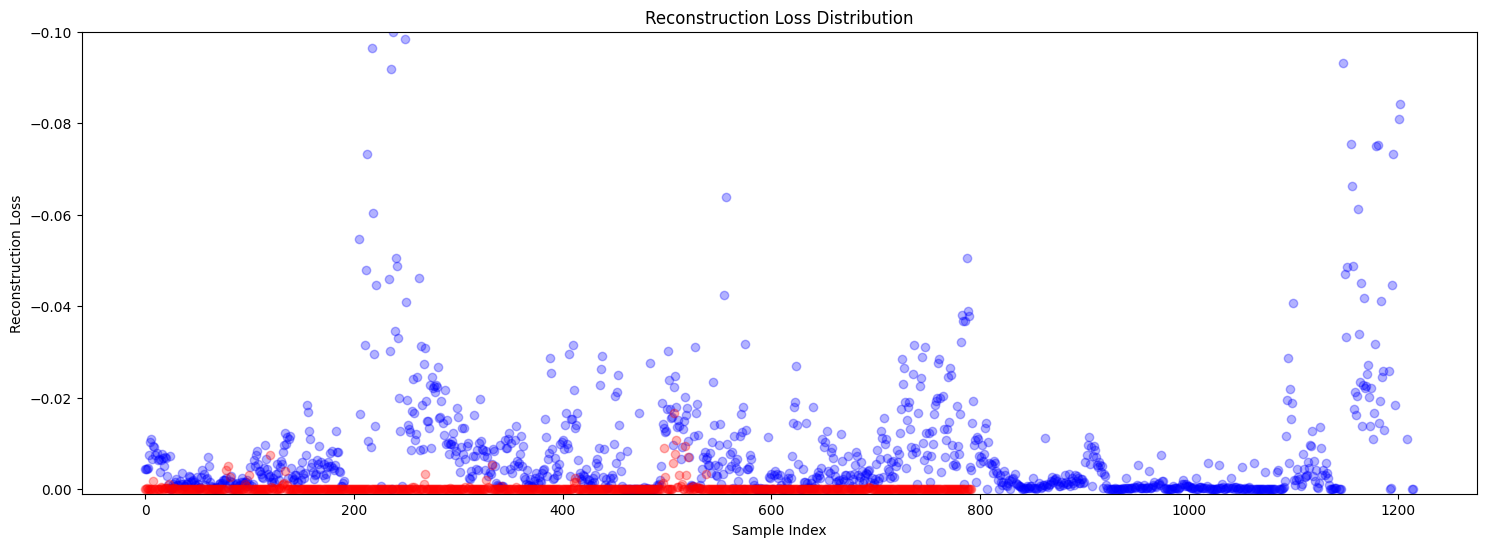

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))

plt.scatter(range(len(val_audio_normal)), scores_audio[:len(val_audio_normal)], color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(val_audio)), scores_audio[len(val_audio_normal):], color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
plt.ylim(0.001,-0.1)

In [6]:
# # Train ABOD for audio data
# abod_audio = ABOD(contamination=0.5)  # Adjust contamination parameter as needed
# abod_audio.fit(np.mean(train_audio, axis=-1))

# # Train ABOD for IMU data
# abod_imu = ABOD(contamination=0.5)  # Adjust contamination parameter as needed
# abod_imu.fit(train_imu)

ABOD(contamination=0.5, method='fast', n_neighbors=5)

In [7]:
audio_pre = abod_audio.predict(np.mean(val_audio,axis=-1))
imu_pre = abod_imu.predict(val_imu)
audio_norm_pre = abod_audio.predict(np.mean(val_audio_normal,axis=-1))
imu_norm_pre = abod_imu.predict(val_imu_normal)

In [9]:
distance_audio = abod_audio.decision_function(np.mean(val_audio,axis=-1))
distance_imu   = abod_imu.decision_function(val_imu)

distance_audio_normal = abod_audio.decision_function(np.mean(val_audio_normal,axis=-1))
distance_imu_normal   = abod_imu.decision_function(val_imu_normal)

mean_distance_audio = np.mean(distance_audio_normal)
mean_distance_imu = np.mean(distance_imu_normal)

distance_audio = np.where(distance_audio >= mean_distance_audio, 1, 0)
distance_imu = np.where(distance_imu >= mean_distance_imu, 1, 0)

FN  = np.sum(distance_audio + distance_imu !=0)
TN  = np.sum(distance_audio + distance_imu ==0)


distance_audio_normal = np.where(distance_audio_normal >= mean_distance_audio, 1, 0)
distance_imu_normal = np.where(distance_imu_normal >= mean_distance_imu, 1, 0)

TP = np.sum(distance_audio_normal + distance_imu_normal !=0)
FP = np.sum(distance_audio_normal + distance_imu_normal ==0)
print(TP,FP)
print(FN,TN)


1209 7
762 0
